# **Step 0: 필요한 라이브러리 등 불러오기**

In [39]:
!pip install osmnx
!pip install osmnx openpyxl

from geopy.geocoders import Nominatim  # geocoding을 위한 geopy
from geopy.extra.rate_limiter import RateLimiter  # 요청 제한 관리
from geopy.distance import geodesic
import folium
import osmnx as ox  # OSMnx 라이브러리
import networkx as nx  # 그래프 조작용
import pandas as pd  # 데이터 처리용
import json           # JSON 파일 파싱용
from google.colab import files # Colab 파일 업로드용
import io
import math
import os
import heapq

# **Step 1: 지하철 네트워크 구축**

In [43]:
# Step1-1: Colab 파일 업로드 및 로드
# ------------------------------------
# 파일 불러오기
print("1) data-metro-station-1.0.0.json")
print("2) data-metro-line-1.0.0.json")
print("3) metropolitan_rail.json.json")

uploaded = files.upload()

1) data-metro-station-1.0.0.json
2) data-metro-line-1.0.0.json
3) metropolitan_rail.json.json


Saving metropolitan_rail.json to metropolitan_rail (1).json
Saving data-metro-line-1.0.0.json to data-metro-line-1.0.0 (4).json
Saving data-metro-station-1.0.0.json to data-metro-station-1.0.0 (3).json


In [45]:
# JSON 로드 함수
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

line_data    = load_json('data-metro-station-1.0.0.json')['DATA']
station_data = load_json('data-metro-line-1.0.0.json')['DATA']
metro_times  = load_json('metropolitan_rail.json')

In [47]:
G_metro = nx.Graph()

# metro_lines가 리스트라면 그대로 반복
for line in metro_lines:
    for segment in line['node']:
        st_a, st_b = segment['station']
        for st in (st_a, st_b):
            G_metro.add_node(
                st['station_cd'],
                name=st['name'],
                line=st['line'],
                lat=st['lat'],
                lng=st['lng']
            )
        G_metro.add_edge(
            st_a['station_cd'],
            st_b['station_cd'],
            line=line['line'],
            weight=1
        )

print("지하철 역 수:", G_metro.number_of_nodes())
print("지하철 엣지 수:", G_metro.number_of_edges())

지하철 역 수: 785
지하철 엣지 수: 763


In [48]:
# 역 이름 → 위도/경도 매핑
station_coords = {s['name']: (s['lat'], s['lng']) for s in station_data}

KeyError: 'name'

In [19]:
# 파일명 검색 헬퍼: 업로드된 키 중에 substring 포함, ext로 끝나는 항목 반환
def find_uploaded(substring, ext):
    for fname in uploaded.keys():
        if substring.lower() in fname.lower() and fname.lower().endswith(ext):
            print(f"[로딩] '{fname}' 파일 사용")
            return uploaded[fname]
    raise FileNotFoundError(f"업로드된 파일 중 '{substring}*{ext}'에 매칭되는 파일이 없습니다.")


In [21]:
print("[4/5] 지하철 데이터 로드 중...")
station_json = json.loads(find_uploaded('data-metro-station', '.json').decode('utf-8-sig'))
line_json    = json.loads(find_uploaded('data-metro-line',    '.json').decode('utf-8-sig'))
# 실제 역 리스트와 노선 리스트는 'DATA' 필드에 위치
metro_stations = station_json.get('DATA', [])
metro_lines    = line_json.get('DATA', [])
print(f"지하철 역 개수: {len(metro_stations)}, 노선 개수: {len(metro_lines)}\n")

[4/5] 지하철 데이터 로드 중...
[로딩] 'data-metro-station-1.0.0 (1).json' 파일 사용
[로딩] 'data-metro-line-1.0.0 (2).json' 파일 사용
지하철 역 개수: 785, 노선 개수: 24



# **Step 2: 지도기반 시각화**

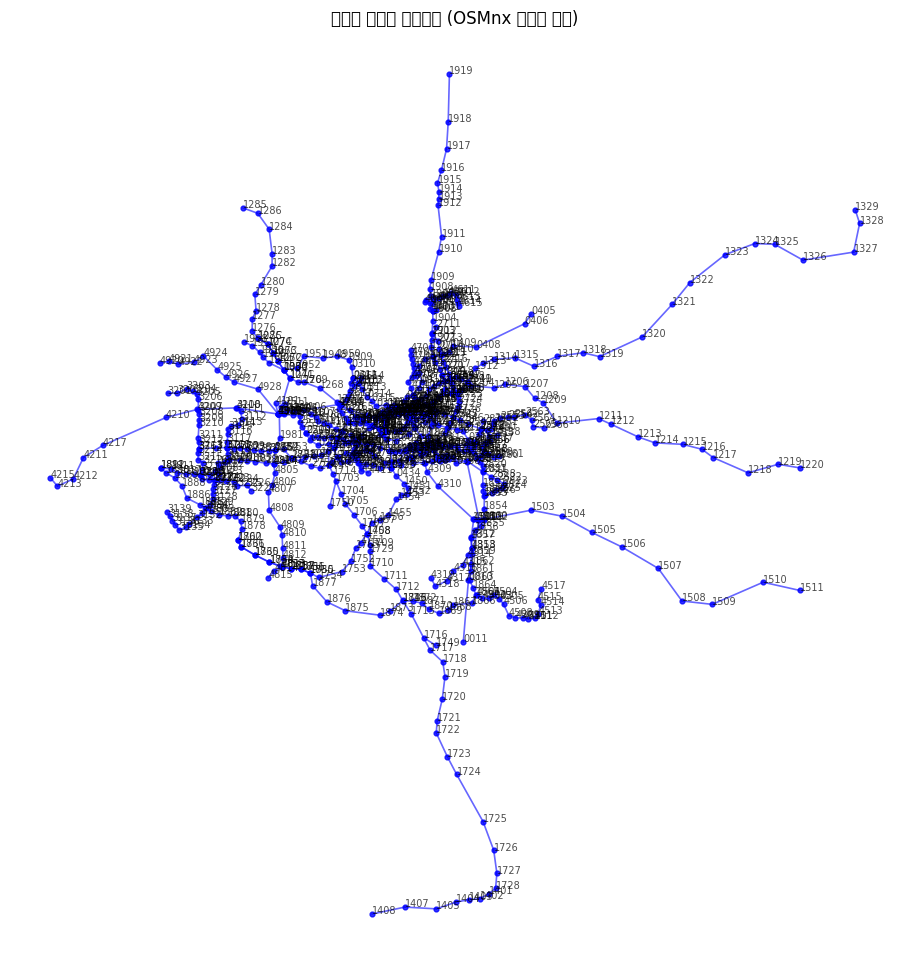

In [34]:
import matplotlib.pyplot as plt

# (1) 지하철 노드 좌표 dict 준비: (경도, 위도) 형식!
metro_pos = {n: (data['lng'], data['lat']) for n, data in G_metro.nodes(data=True) if 'lat' in data and 'lng' in data}
# (2) 엣지 목록 생성
metro_edges = [(u, v) for u, v in G_metro.edges() if u in metro_pos and v in metro_pos]

# (3) 지도 스타일 Figure 생성
fig, ax = plt.subplots(figsize=(12, 12))

# (4) 지하철 엣지(노선) 시각화
for u, v in metro_edges:
    lngs = [metro_pos[u][0], metro_pos[v][0]]
    lats = [metro_pos[u][1], metro_pos[v][1]]
    ax.plot(lngs, lats, color='blue', linewidth=1.2, alpha=0.6)

# (5) 지하철 노드(역) 시각화
lngs = [metro_pos[n][0] for n in metro_pos]
lats = [metro_pos[n][1] for n in metro_pos]
ax.scatter(lngs, lats, c='blue', s=12, alpha=0.8)

###(6) 보기 편하게 역 이름(선택)###
for n, (lng, lat) in metro_pos.items():
    if hasattr(G_metro.nodes[n], 'name'):
        name = G_metro.nodes[n]['name']
    else:
        name = str(n)
    ax.text(lng, lat, name, fontsize=7, alpha=0.7)

ax.set_title("서울시 지하철 네트워크 (OSMnx 스타일 지도)")
ax.set_xlabel("경도")
ax.set_ylabel("위도")
ax.set_aspect('equal')
plt.axis('off')
plt.show()


In [31]:
# 실제 지도 기반 시각화 (folium)
center = [37.5665, 126.9780]
m = folium.Map(location=center, zoom_start=12, tiles='CartoDB positron')


# 지하철 경로
for u, v in G_metro.edges():
    u_node = G_metro.nodes[u]
    v_node = G_metro.nodes[v]
    if 'lat' in u_node and 'lng' in u_node and 'lat' in v_node and 'lng' in v_node:
        coord = [(u_node['lat'], u_node['lng']), (v_node['lat'], v_node['lng'])]
        folium.PolyLine(
            locations=coord,
            color='blue',
            weight=2,
            opacity=0.6
        ).add_to(m)

# 지하철 정점
for n, data in G_metro.nodes(data=True):
    if 'lat' in data and 'lng' in data:
        folium.CircleMarker(
            location=(data['lat'], data['lng']),
            radius=3,
            color='blue',
            fill=True,
            fill_opacity=0.7,
            popup=data.get('name', str(n))
        ).add_to(m)

m


In [35]:
# Folium 중심 좌표, 범위는 지하철 역 좌표 기준으로 잡으세요.
lat_list = [data['lat'] for n, data in G_metro.nodes(data=True) if 'lat' in data and 'lng' in data]
lng_list = [data['lng'] for n, data in G_metro.nodes(data=True) if 'lat' in data and 'lng' in data]
lat_min, lat_max = min(lat_list), max(lat_list)
lng_min, lng_max = min(lng_list), max(lng_list)

m = folium.Map(location=[(lat_min + lat_max) / 2, (lng_min + lng_max) / 2], zoom_start=11)

# 지하철 경로 (노선)
for u, v in G_metro.edges():
    u_node = G_metro.nodes[u]
    v_node = G_metro.nodes[v]
    if 'lat' in u_node and 'lng' in u_node and 'lat' in v_node and 'lng' in v_node:
        folium.PolyLine([(u_node['lat'], u_node['lng']), (v_node['lat'], v_node['lng'])],
                        color='blue', weight=2, opacity=0.6).add_to(m)

# 지하철 정점 (역)
for n, data in G_metro.nodes(data=True):
    if 'lat' in data and 'lng' in data:
        folium.CircleMarker(location=(data['lat'], data['lng']),
                            radius=3, color='blue', fill=True, fill_opacity=0.7,
                            popup=data.get('name', str(n))).add_to(m)

m


# **Step 3: 사용자로부터 출발지, 도착지 입력 받기 / 시간대 확인**

In [11]:
# Nominatim geocoder 설정 (rate limiter로 1초 간격 요청)
geolocator = Nominatim(user_agent="transit_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [14]:
def get_location(prompt):
    """
    사용자에게 주소, 건물명 또는 주요 거점 시설명(지하철역 등)을 입력받아 위경도로 변환하고, 사용자 확인 후 반환합니다.
    - 주소/건물명 입력 예시: "강남구 청담동 힐스테이트", "힐스테이트 용산"
    - 주요 거점 시설 입력 예시: "강남역", "서울역", "여의도공원"
    - 변환된 위치가 맞지 않을 경우 재검색 또는 수동 좌표 입력을 지원합니다.

    Args:
        prompt (str): "출발지" 또는 "도착지" 등 안내문자열
    Returns:
        tuple: (latitude, longitude)
    """
    while True:
        user_input = input(f"[{prompt}] 주소/시설명을 입력하세요 (예: 강남역, 한남현대힐스테이트): ").strip()
        if not user_input:
            print("입력이 없습니다. 다시 입력해주세요.")
            continue
        # 검색 쿼리에 도시 추가
        query = f"{user_input}, Seoul, South Korea"
        try:
            location = geocode(query)
        except Exception as e:
            print(f"주소/시설 검색 중 오류 발생: {e}")
            continue
        if not location:
            print(f"'{user_input}'를 찾을 수 없습니다. 다른 표현으로 다시 시도해주세요.")
            continue
        # 변환 결과 표시 및 확인
        lat, lon = location.latitude, location.longitude
        name = location.address if hasattr(location, 'address') else query
        print(f"검색 결과: {name}\n위도={lat:.6f}, 경도={lon:.6f}")
        confirm = input("이 위치가 맞습니까? [Y/n]: ").strip().lower()
        if confirm in ['', 'y', 'yes']:
            return lat, lon
        # 위치가 다를 경우 재검색 또는 수동 입력 옵션
        print("다시 주소/시설명을 입력하거나, 수동으로 좌표를 입력할 수 있습니다.")
        manual = input("수동 좌표 입력을 하시겠습니까? [y/N]: ").strip().lower()
        if manual in ['y', 'yes']:
            while True:
                coord_input = input("위도,경도 형식으로 입력하세요 (예: 37.535861,127.0117095): ").strip()
                try:
                    lat_str, lon_str = coord_input.split(',')
                    lat_manual, lon_manual = float(lat_str), float(lon_str)
                    return lat_manual, lon_manual
                except Exception:
                    print("잘못된 형식입니다. '위도,경도' 형식을 지켜 입력해주세요.")
        else:
            print("입력값을 다시 확인해주세요.")

get_location('출발지')

[출발지] 주소/시설명을 입력하세요 (예: 강남역, 한남현대힐스테이트): 명지대학교
검색 결과: 명지대학교 도서관, 34, 거북골로, 남가좌동, 남가좌2동, 서대문구, 서울특별시, 03665, 대한민국
위도=37.580387, 경도=126.923275
이 위치가 맞습니까? [Y/n]: Y


(37.5803867, 126.9232753)

In [17]:
if __name__ == '__main__':
    # 출발지 입력
    print("### 출발지 입력 ###")
    start_lat, start_lon = get_location("출발지")

    # 도착지 입력
    print("### 도착지 입력 ###")
    end_lat, end_lon = get_location("도착지")

    # 결과 출력
    print(f"입력된 정보 -> 출발: ({start_lat:.6f}, {start_lon:.6f}), 도착: ({end_lat:.6f}, {end_lon:.6f})")


### 출발지 입력 ###
[출발지] 주소/시설명을 입력하세요 (예: 강남역, 한남현대힐스테이트): 명지대학교
검색 결과: 명지대학교 도서관, 34, 거북골로, 남가좌동, 남가좌2동, 서대문구, 서울특별시, 03665, 대한민국
위도=37.580387, 경도=126.923275
이 위치가 맞습니까? [Y/n]: Y
### 도착지 입력 ###
[도착지] 주소/시설명을 입력하세요 (예: 강남역, 한남현대힐스테이트): 고려대학교 우당교양관
'고려대학교 우당교양관'를 찾을 수 없습니다. 다른 표현으로 다시 시도해주세요.
[도착지] 주소/시설명을 입력하세요 (예: 강남역, 한남현대힐스테이트): 고려대학교
검색 결과: 고려대학교 서울캠퍼스, 145, 안암로, 안암동5가, 안암동, 성북구, 서울특별시, 02841, 대한민국
위도=37.587963, 경도=127.032346
이 위치가 맞습니까? [Y/n]: Y
입력된 정보 -> 출발: (37.580387, 126.923275), 도착: (37.587963, 127.032346)


# **Step 4: 사용자 기반 경로 후보군 탐색 (최소 시간, 환승, 도보)**

In [38]:
import networkx as nx
import math

def haversine(u, v, G):
    lat1, lon1 = G.nodes[u]['lat'], G.nodes[u]['lng']
    lat2, lon2 = G.nodes[v]['lat'], G.nodes[v]['lng']
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δφ = math.radians(lat2 - lat1)
    Δλ = math.radians(lon2 - lon1)
    a = math.sin(Δφ/2)**2 + math.cos(φ1)*math.cos(φ2)*math.sin(Δλ/2)**2
    return 6371000 * 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

def find_nearest_station(lat, lon, G):
    min_dist = float('inf')
    nearest = None
    for n, data in G.nodes(data=True):
        if 'lat' in data and 'lng' in data:
            d = math.sqrt((lat - data['lat'])**2 + (lon - data['lng'])**2)
            if d < min_dist:
                min_dist = d
                nearest = n
    return nearest

def get_metro_route(G_metro, start_lat, start_lon, end_lat, end_lon):
    # 1. 출발/도착지에서 가장 가까운 지하철역(노드) 찾기
    start_node = find_nearest_station(start_lat, start_lon, G_metro)
    end_node   = find_nearest_station(end_lat, end_lon, G_metro)
    print(f"출발역: {G_metro.nodes[start_node]['name']}, 도착역: {G_metro.nodes[end_node]['name']}")

    # 2. edge별 weight(거리, m) 갱신 (한 번만 해주면 됨)
    for u, v, d in G_metro.edges(data=True):
        u_node = G_metro.nodes[u]
        v_node = G_metro.nodes[v]
        d['weight'] = haversine(u, v, G_metro)

    # 3. A* 최단거리(최소 시간) 경로 탐색
    route = nx.astar_path(
        G_metro, start_node, end_node,
        heuristic=lambda u, v: haversine(u, v, G_metro),
        weight='weight'
    )
    return route

# 사용 예시 (변수는 이미 위에서 입력받은 것 활용)
route = get_metro_route(G_metro, start_lat, start_lon, end_lat, end_lon)
print("최적 지하철 경로:")
for node in route:
    print(f"  {G_metro.nodes[node]['name']}")


출발역: 증산, 도착역: 안암
최적 지하철 경로:
  증산
  디지털미디어시티
  월드컵경기장
  마포구청
  망원
  합정
  상수
  광흥창
  대흥
  공덕
  효창공원앞
  삼각지
  녹사평
  이태원
  한강진
  버티고개
  약수
  청구
  신당
  동묘앞
  창신
  보문
  안암


\
\
\

In [49]:
import json

with open('data-metro-station-1.0.0.json', encoding='utf-8') as f:
    stations = json.load(f)['DATA']

# 노선이 여러 개인 역만 선택 (ex: 'line' 필드가 리스트이거나, 'line_list' 필드 사용)
transfer_stations = [st for st in stations if isinstance(st.get('line'), list) and len(st['line']) > 1]
print("환승역 개수:", len(transfer_stations))
for st in transfer_stations:
    print(st['name'], st['line'])


환승역 개수: 0
